Parameter Tuning for TV-Regularized Abel Inversion
==================================================

This example demonstrates the use of
[scico.ray.tune](../_autosummary/scico.ray.tune.rst) to tune
parameters for the companion [example script](ct_abel_tv_admm.rst). The
`ray.tune` class API is used in this example.

This script is hard-coded to run on CPU only to avoid the large number of
warnings that are emitted when GPU resources are requested but not available,
and due to the difficulty of supressing these warnings in a way that does
not force use of the CPU only. To enable GPU usage, comment out the
`os.environ` statements near the beginning of the script, and change the
value of the "gpu" entry in the `resources` dict from 0 to 1. Note that
two environment variables are set to suppress the warnings because
`JAX_PLATFORMS` was intended to replace `JAX_PLATFORM_NAME` but this change
has yet to be correctly implemented
(see [google/jax#6805](https://github.com/google/jax/issues/6805) and
[google/jax#10272](https://github.com/google/jax/pull/10272).

In [1]:
# isort: off
import os

os.environ["JAX_PLATFORM_NAME"] = "cpu"
os.environ["JAX_PLATFORMS"] = "cpu"

import numpy as np

import jax

from scico import functional, linop, loss, metric, plot
from scico.examples import create_circular_phantom
from scico.linop.abel import AbelProjector
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.ray import tune
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 256  # image size
x_gt = create_circular_phantom((N, N), [0.4 * N, 0.2 * N, 0.1 * N], [1, 0, 0.5])

Set up the forward operator and create a test measurement.

In [3]:
A = AbelProjector(x_gt.shape)
y = A @ x_gt
np.random.seed(12345)
y = y + np.random.normal(size=y.shape)

Define performance evaluation class.

In [4]:
class Trainable(tune.Trainable):
    """Parameter evaluation class."""

    def setup(self, config, x_gt, y):
        """This method initializes a new parameter evaluation object. It
        is called once when a new parameter evaluation object is created.
        The `config` parameter is a dict of specific parameters for
        evaluation of a single parameter set (a pair of parameters in
        this case). The remaining parameters are objects that are passed
        to the evaluation function via the ray object store.
        """
        # Put main arrays on jax device.
        self.x_gt, self.y = jax.device_put([x_gt, y])
        # Set up problem to be solved.
        self.A = AbelProjector(self.x_gt.shape)
        self.f = loss.SquaredL2Loss(y=self.y, A=self.A)
        self.C = linop.FiniteDifference(input_shape=self.x_gt.shape)
        self.reset_config(config)

    def reset_config(self, config):
        """This method is only required when `scico.ray.tune.Tuner` is
        initialized with `reuse_actors` set to ``True`` (the default). In
        this case, a set of parameter evaluation processes and
        corresponding objects are created once (including initialization
        via a call to the `setup` method), and this method is called when
        switching to evaluation of a different parameter configuration.
        If `reuse_actors` is set to ``False``, then a new process and
        object are created for each parameter configuration, and this
        method is not used.
        """
        # Extract solver parameters from config dict.
        λ, ρ = config["lambda"], config["rho"]
        # Set up parameter-dependent functional.
        g = λ * functional.L1Norm()
        # Define solver.
        self.solver = ADMM(
            f=self.f,
            g_list=[g],
            C_list=[self.C],
            rho_list=[ρ],
            x0=A.inverse(self.y),
            maxiter=10,
            subproblem_solver=LinearSubproblemSolver(),
        )
        return True

    def step(self):
        """This method is called for each step in the evaluation of a
        single parameter configuration. The maximum number of times it
        can be called is controlled by the `num_iterations` parameter
        in the initialization of a `scico.ray.tune.Tuner` object.
        """
        # Perform 10 solver steps for every ray.tune step
        x_admm = self.solver.solve()
        return {"psnr": float(metric.psnr(self.x_gt, x_admm))}

Define parameter search space and resources per trial.

In [5]:
config = {"lambda": tune.loguniform(1e0, 1e2), "rho": tune.loguniform(1e1, 1e3)}
resources = {"gpu": 0, "cpu": 1}  # gpus per trial, cpus per trial

Run parameter search.

In [6]:
tuner = tune.Tuner(
    tune.with_parameters(Trainable, x_gt=x_gt, y=y),
    param_space=config,
    resources=resources,
    metric="psnr",
    mode="max",
    num_samples=100,  # perform 100 parameter evaluations
    num_iterations=10,  # perform at most 10 steps for each parameter evaluation
)
results = tuner.fit()

P:   0 R:   0 T: 100  psnr: 4.00e+01 at lambda: 3.10e+01, rho: 8.99e+01


Display best parameters and corresponding performance.

In [7]:
best_result = results.get_best_result()
best_config = best_result.config
print(f"Best PSNR: {best_result.metrics['psnr']:.2f} dB")
print("Best config: " + ", ".join([f"{k}: {v:.2e}" for k, v in best_config.items()]))

Best PSNR: 39.96 dB
Best config: lambda: 3.10e+01, rho: 8.99e+01


Plot parameter values visited during parameter search. Marker sizes are
proportional to number of iterations run at each parameter pair. The best
point in the parameter space is indicated in red.

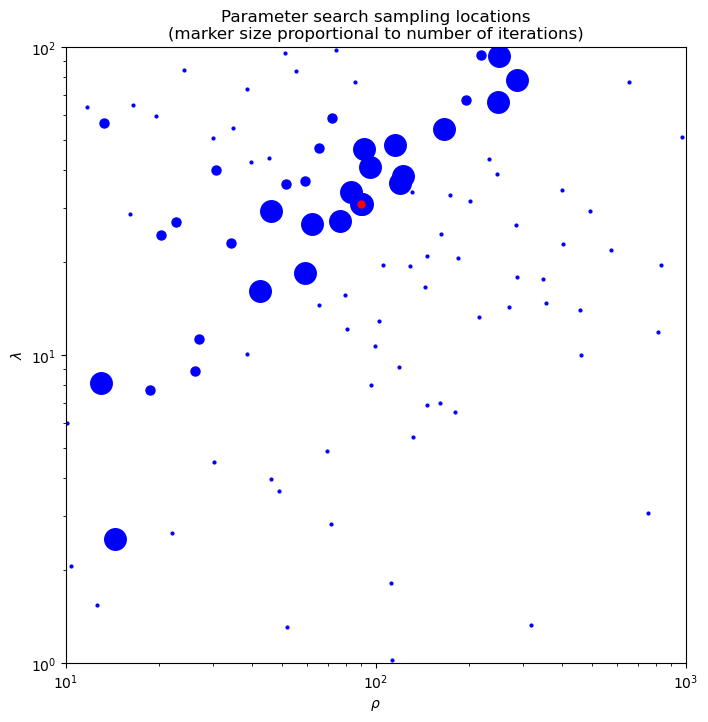

In [8]:
fig = plot.figure(figsize=(8, 8))
trials = results.get_dataframe()
for t in trials.iloc:
    n = t["training_iteration"]
    plot.plot(
        t["config/lambda"],
        t["config/rho"],
        ptyp="loglog",
        lw=0,
        ms=(0.5 + 1.5 * n),
        marker="o",
        mfc="blue",
        mec="blue",
        fig=fig,
    )
plot.plot(
    best_config["lambda"],
    best_config["rho"],
    ptyp="loglog",
    title="Parameter search sampling locations\n(marker size proportional to number of iterations)",
    xlbl=r"$\rho$",
    ylbl=r"$\lambda$",
    lw=0,
    ms=5.0,
    marker="o",
    mfc="red",
    mec="red",
    fig=fig,
)
ax = fig.axes[0]
ax.set_xlim([config["rho"].lower, config["rho"].upper])
ax.set_ylim([config["lambda"].lower, config["lambda"].upper])
fig.show()

Plot parameter values visited during parameter search and corresponding
reconstruction PSNRs.The best point in the parameter space is indicated
in red.

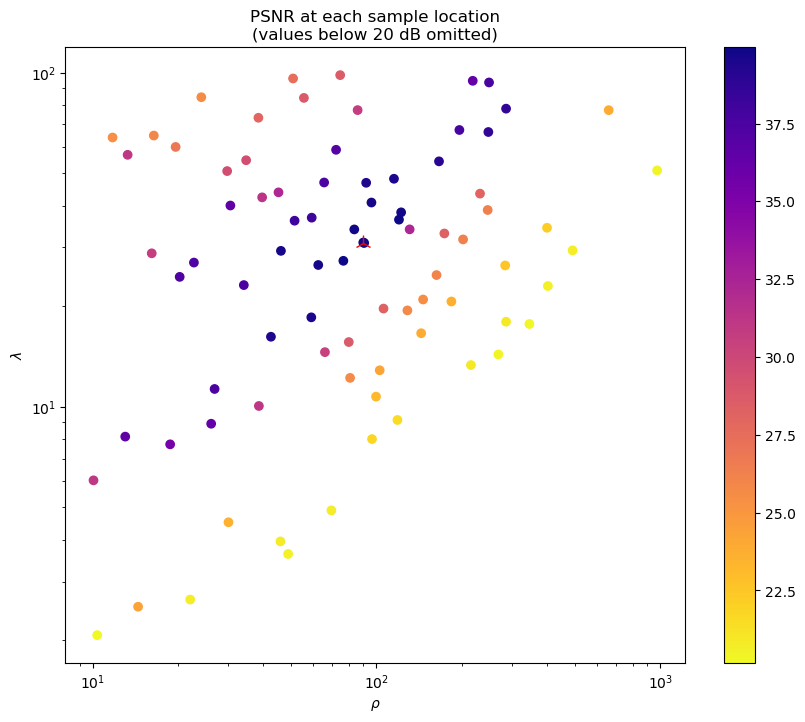

In [9]:
𝜌 = [t["config/rho"] for t in trials.iloc]
𝜆 = [t["config/lambda"] for t in trials.iloc]
psnr = [t["psnr"] for t in trials.iloc]
minpsnr = min(max(psnr), 20.0)
𝜌, 𝜆, psnr = zip(*filter(lambda x: x[2] >= minpsnr, zip(𝜌, 𝜆, psnr)))
fig, ax = plot.subplots(figsize=(10, 8))
sc = ax.scatter(𝜌, 𝜆, c=psnr, cmap=plot.cm.plasma_r)
fig.colorbar(sc)
plot.plot(
    best_config["lambda"],
    best_config["rho"],
    ptyp="loglog",
    lw=0,
    ms=12.0,
    marker="2",
    mfc="red",
    mec="red",
    fig=fig,
    ax=ax,
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$\lambda$")
ax.set_title("PSNR at each sample location\n(values below 20 dB omitted)")
fig.show()